# Operations Analysis

The focus of this analysis is to determine the tendency of the total number of calls per day. The most straight forward way to do this is to fit a linear regression to the scatter of number of calls per day.

This type of document is a Python Notebook. It may not be the best form of presentation for a client or an Investor. But within de DIA team its probably a great way to share analysis. The outputs of the code are right next to the code that generated it. So modification is trivial. Its also a great way to make tutorials for new team members to catch up faster.

In [1]:
#importing necessary modules
import numpy as np #numerical vector operations
import matplotlib.pyplot as plt #ploting module
import psycopg2 #module for postresql access qith python
import pandas as pd #Module that handels DataFrames in a way analagous to SQL
import time #Module to deal with time stamps
%matplotlib inline

## Accessing the Database

The psycopg2 module is used to connected to the database.

----------------OMITED----------------

This part of the code was omited since GitHub is a public repository. 
And we don't want the general public to have access to the database server.

-------------------------------------------.

## Downloading relevent results

This segment queries the database for the table calls already joined with cities and payment_methods. It then downloads the result of the query from the server to your python machine. Finally the data is put into a Pandas DataFrame, which is a practical wrapper for tabled data.

#### Note on efficiency:
It's would be ideal to do most of the table computations inside the posgresql server
and only download the result to plot it, or to make a more elaborate analysis. This avoids strains on your local 
memory.
Here we choose to download the whole database, because it is not very big and so we prefer not to keep an open 
connection with the server.

In [3]:
try:
    cursor.execute("""SELECT 
                        ca.id,
                        ci.city_name,
                        ca.request_time,
                        ca.is_ride,
                        p.payment_name
                      FROM 
                          calls AS ca
                          LEFT JOIN cities AS ci 
                              ON ca.city_id=ci.id
                          LEFT JOIN payment_methods AS p
                              ON ca.payment_method=p.id
                      """)
except Exception as e:
    print('Error!')
    print(e)
    print('Rolling back')
    conn.rollback()
    raise

print('Query executed')
rows = cursor.fetchall()
print('results recovered')
columns = ['id','city_name','request_time','is_ride','payment_name']
calls = pd.DataFrame(rows, columns=columns)
print('Dataframe made')
conn.close()
calls.head()

Query executed
results recovered
Dataframe made


,id,city_name,request_time,is_ride,payment_name
0,2411009,Sao Paulo,2015-05-27 08:00:00,True,inapp_credit
1,2411010,Porto Alegre,2015-05-26 10:00:00,True,debit
2,2411011,Rio de Janeiro,2015-05-21 13:00:00,True,money
3,2411012,Sao Paulo,2015-05-29 20:00:00,True,debit
4,2411013,Porto Alegre,2015-05-19 13:00:00,True,money


## Tendencies

Here we are going to try to see the overall tendency of the number of calls per day, over time. That is to say, we want to know if the number of calls is growning or if we are seeing a reduction in the number of calls per day.
To do this we will do a linear regression of the number of calls per day with respect to the time. If the resulting angular coefficient is negative that indicates a general decrease over time. If it is positive, we are looking at an increase over time.

Calls Per Day: angular coeficient -0.0435563822751 linear coeficient 62606330.1


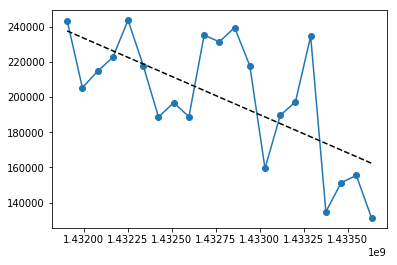

In [4]:
def plot_trends(calls, name):
    
    calls_per_day = calls[['id','request_time']].groupby(calls.set_index('request_time').index.date).count()
    #Putting values in lists so they can be plotted
    dates = calls_per_day.index.get_values()
    num_ids = calls_per_day['id'].tolist()

    #transformes the date from a datetime object to an integer
    days = [time.mktime(date.timetuple()) for date in dates]

    #We fit a polinomial of order 1 (a line) to our data
    coef = np.polyfit(days,num_ids,1)

    #generate a function with our coefitients 
    fit_pol = np.poly1d(coef)

    #deletes the auxiliary Dataframe to avoid memory strains.
    del calls_per_day

    #Prints and plots the relevant informations
    m, b = coef
    print('%s: angular coeficient %s linear coeficient %s' % (name, m, b))
    return plt.plot(days, num_ids, '-o', days, fit_pol(days), '--k', label=name)

plot0 = plot_trends(calls,'Calls Per Day')

## Oh no! Calls are decreasing

It seems like the number of calls per day is decreasing! This is bad for business. But what could the problem be? Maybe looking city by city we can get a sense of whether there is a problem with a specific city or if this is a generalized problem.

## By city

So lets take a look at the trends by city!

Sao Paulo: angular coeficient -0.0248613516114 linear coeficient 35734824.2961
Porto Alegre: angular coeficient -0.00299963924964 linear coeficient 4311652.44156
Rio de Janeiro: angular coeficient -0.0101244588745 linear coeficient 14552033.5671
Recife: angular coeficient -0.00260963804714 linear coeficient 3750943.28398
Belo Horizonte: angular coeficient -0.00296129449254 linear coeficient 4256876.51126


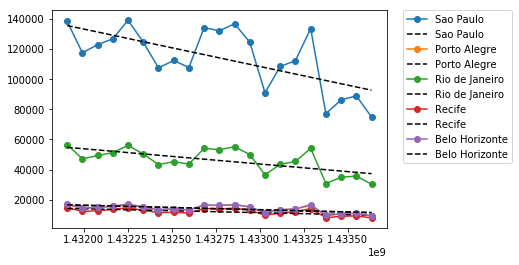

In [5]:
city_names = calls['city_name'].unique()

city_name = city_names[1]

for city_name in city_names:
    #plots each city on the same plot
    city_calls = calls.loc[calls['city_name'] == city_name]
    _ = plot_trends(city_calls, city_name)
_ = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Conclusion

Ok, so the plot is a bit cluttered, but from the coefficients its very clear that ALL the cities are seeing a decrease in business. This is very bad! Why could this be? Looking at the request_time dates we can tell that this data is from May/June of 2015. This is more or less the period where Uber was starting to gain market in Brasil.

This can be confirmed by looking at Google trends for the word "Uber" in Brasil. As you can see below, there was a peek of interest in Uber at the time of this Data where 99 was experiencing an all around decrease in business.

https://trends.google.com.br/trends/explore?date=today%205-y&geo=BR&q=Uber

![Google trends on the word 'Uber'](img/Uber_trends.png)


Probably the best thing to do in this situation is to do what 99 actually did. Which is to open up a 99 POP to compete with the same kind of service as Uber. As it seems that people are starting to prefer this type of locomotion.

## Final comments 

While doing this assignment I noticed that ALL of the cities have exactly the same calls per day distribution changing only the scale. Also, while plotting the distributions of calls per hour of the day for the MetaBase DashBoard the SAME EXACT distribution of calls throughout the days was present in every city. This is probably NOT a coincidence, as it would be HIGHLY unlikely that these cities are SO similar. 

My guess to explain this phenomenon is that, since this data was shared with people from outside the company and is potentially sensitive information the City labels where randomly permutated. This would explain why all cities have the same distribution: Because they where drawn from the same distribution.

With that observed, our previous analysis on the trends of each city is completely innocuous. We would need to analyse the REAL data to know the trends for each city.

## Trends By City corrected for scale

Below is the plots of each cities calls per day ajusted for scale to justify my suspition that the labels where permutated.

Sao Paulo: angular coeficient -0.0248613516114 linear coeficient 35734824.2961
Porto Alegre: angular coeficient -0.00299963924964 linear coeficient 4311652.44156
Rio de Janeiro: angular coeficient -0.0101244588745 linear coeficient 14552033.5671
Recife: angular coeficient -0.00260963804714 linear coeficient 3750943.28398
Belo Horizonte: angular coeficient -0.00296129449254 linear coeficient 4256876.51126


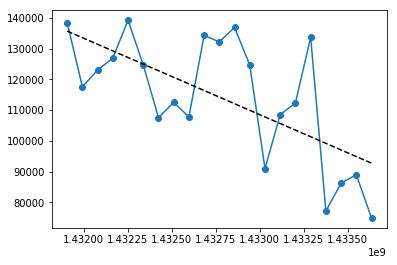

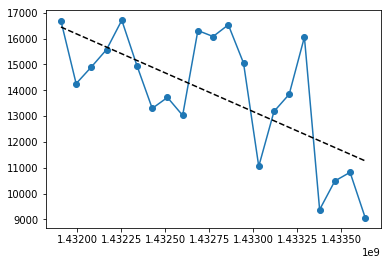

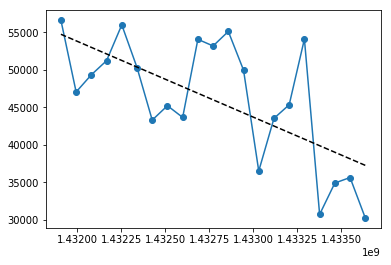

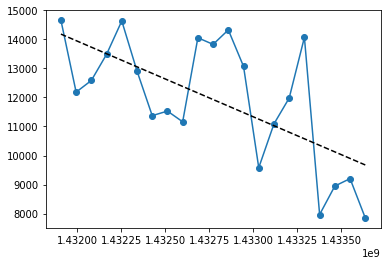

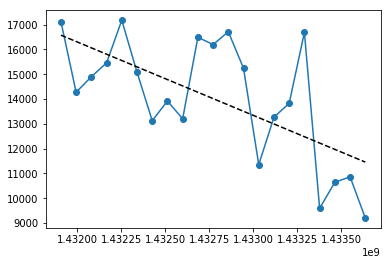

In [6]:
for city_name in city_names:
    #plots each city on the same plot
    fig = plt.figure()
    city_calls = calls.loc[calls['city_name'] == city_name]
    _ = plot_trends(city_calls, city_name)